## Dependecies

In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {DEVICE}")

Device used: cpu


## Set random seed for reproducibility

In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## Models

In [3]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 7

In [ ]:
def init_model(model_name):
    match model_name:
        case "EfficientNet_B0":
            weights = models.EfficientNet_B0_Weights.DEFAULT
            data_transform = weights.transforms()
            model = models.efficientnet_b0(weights=weights)
            num_features = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_features, 3) 
        case "ResNet50":
            weights = models.ResNet50_Weights.DEFAULT
            data_transform = weights.transforms()
            model = models.resnet50()
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 3)
        case "OUR-CNN-PLACEHOLDER":
            #MODEL CNN
            #MODEL TRANSORM
            pass
        case _:
            raise ValueError(f"Model {model_name} is not supported.")
    
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    return model, data_transform, criterion, optimizer

## Prepare DataLoaders

In [5]:
def init_dataloaders(train_path, test_path, data_transform, val_ratio = 0.1):
    train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform)
    test_dataset = datasets.ImageFolder(root=test_path, transform=data_transform)
    classes = train_dataset.classes
    val_size = int(val_ratio * len(train_dataset))
    train_size = len(train_dataset) - val_size

    set_seed(42)
    val_dataset, train_dataset = random_split(train_dataset, [val_size, train_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader, classes


## Training loop

In [6]:
def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    best_val_accuracy = 0

    history = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        # Training phase
        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = accuracy_score(all_labels, all_preds)

        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_accuracy)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_preds = []
        val_labels = []
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = accuracy_score(val_labels, val_preds)

        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        # Print training and validation results
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
    
    with open(f'{model_name}_history.json', 'w') as f:
        json.dump(history, f)

    print(f"Training complete for {model_name}. Training stats saved to '{model_name}_history.json'.")



# CALL TRAIN

In [2]:
model_names = ["EfficientNet_B0", "ResNet50",]

In [ ]:
train_path = '/kaggle/input/animal-faces/afhq/train'
test_path = '/kaggle/input/animal-faces/afhq/val'

train_loader_classes = {}
test_loaders = {}

for model_name in model_names:
    print(f"Initializing and training model: {model_name}")
    
    model, data_transform, criterion, optimizer = init_model(model_name)
    train_loader, val_loader, test_loader, classes = init_dataloaders(train_path, test_path, data_transform, val_ratio=0.1)

    train_loader_classes[model_name] = classes
    test_loaders[model_name] = test_loader
    
    train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS)
    
    

Initializing and training model: EfficientNet_B0


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 145MB/s]
Training Epoch 1/7: 100%|██████████| 412/412 [04:02<00:00,  1.70it/s]


Epoch [1/7], Train Loss: 0.0658, Train Accuracy: 0.9803, Val Loss: 0.0165, Val Accuracy: 0.9973


Training Epoch 2/7: 100%|██████████| 412/412 [02:36<00:00,  2.63it/s]


Epoch [2/7], Train Loss: 0.0269, Train Accuracy: 0.9908, Val Loss: 0.0180, Val Accuracy: 0.9966


Training Epoch 3/7: 100%|██████████| 412/412 [02:34<00:00,  2.66it/s]


Epoch [3/7], Train Loss: 0.0147, Train Accuracy: 0.9948, Val Loss: 0.0286, Val Accuracy: 0.9897


Training Epoch 4/7: 100%|██████████| 412/412 [02:34<00:00,  2.67it/s]


Epoch [4/7], Train Loss: 0.0136, Train Accuracy: 0.9965, Val Loss: 0.0144, Val Accuracy: 0.9945


Training Epoch 5/7: 100%|██████████| 412/412 [02:34<00:00,  2.67it/s]


Epoch [5/7], Train Loss: 0.0155, Train Accuracy: 0.9953, Val Loss: 0.0119, Val Accuracy: 0.9986


Training Epoch 6/7: 100%|██████████| 412/412 [02:34<00:00,  2.66it/s]


Epoch [6/7], Train Loss: 0.0103, Train Accuracy: 0.9967, Val Loss: 0.0191, Val Accuracy: 0.9932


Training Epoch 7/7: 100%|██████████| 412/412 [02:36<00:00,  2.64it/s]


Epoch [7/7], Train Loss: 0.0070, Train Accuracy: 0.9978, Val Loss: 0.0162, Val Accuracy: 0.9952
Training complete for EfficientNet_B0. Training stats saved to 'EfficientNet_B0_history.json'.
Initializing and training model: ResNet50


Training Epoch 1/7: 100%|██████████| 412/412 [03:40<00:00,  1.87it/s]


Epoch [1/7], Train Loss: 0.6597, Train Accuracy: 0.7238, Val Loss: 0.3580, Val Accuracy: 0.8544


Training Epoch 2/7: 100%|██████████| 412/412 [03:37<00:00,  1.89it/s]


Epoch [2/7], Train Loss: 0.2672, Train Accuracy: 0.8993, Val Loss: 0.1849, Val Accuracy: 0.9221


Training Epoch 3/7: 100%|██████████| 412/412 [03:36<00:00,  1.90it/s]


Epoch [3/7], Train Loss: 0.1672, Train Accuracy: 0.9389, Val Loss: 0.4691, Val Accuracy: 0.8380


Training Epoch 4/7: 100%|██████████| 412/412 [03:36<00:00,  1.90it/s]


Epoch [4/7], Train Loss: 0.1323, Train Accuracy: 0.9531, Val Loss: 0.6782, Val Accuracy: 0.8086


Training Epoch 5/7: 100%|██████████| 412/412 [03:36<00:00,  1.91it/s]


Epoch [5/7], Train Loss: 0.1010, Train Accuracy: 0.9636, Val Loss: 0.0766, Val Accuracy: 0.9727


Training Epoch 6/7: 100%|██████████| 412/412 [03:36<00:00,  1.90it/s]


Epoch [6/7], Train Loss: 0.0716, Train Accuracy: 0.9741, Val Loss: 0.0728, Val Accuracy: 0.9761


Training Epoch 7/7: 100%|██████████| 412/412 [03:36<00:00,  1.90it/s]


Epoch [7/7], Train Loss: 0.0787, Train Accuracy: 0.9726, Val Loss: 0.0874, Val Accuracy: 0.9699
Training complete for ResNet50. Training stats saved to 'ResNet50_history.json'.


## Plot losses

In [ ]:
import itertools
def plot_metrics_from_json(model_names):

    all_train_loss = {}
    all_val_loss = {}
    all_train_acc = {}
    all_val_acc = {}

    for model_name in model_names:
        json_path = f'{model_name}_history.json'
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        all_train_loss[model_name] = data['train_loss']
        all_val_loss[model_name] = data['val_loss']
        all_train_acc[model_name] = data['train_accuracy']
        all_val_acc[model_name] = data['val_accuracy']

    colors = ['b', 'g', 'r']

    plt.figure(figsize=(10, 5))
    for idx, model_name in enumerate(model_names):
        color = colors[idx]
        plt.plot(all_train_loss[model_name], label=f'{model_name} Train Loss', color=color)
        plt.plot(all_val_loss[model_name], label=f'{model_name} Val Loss', color=color, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Across Models')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy (Training and Validation) for all models
    plt.figure(figsize=(10, 5))
    for idx, model_name in enumerate(model_names):
        color = colors[idx]
        plt.plot(all_train_acc[model_name], label=f'{model_name} Train Acc', color=color)
        plt.plot(all_val_acc[model_name], label=f'{model_name} Val Acc', color=color, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Across Models')
    plt.legend()
    plt.grid(True)
    plt.show()

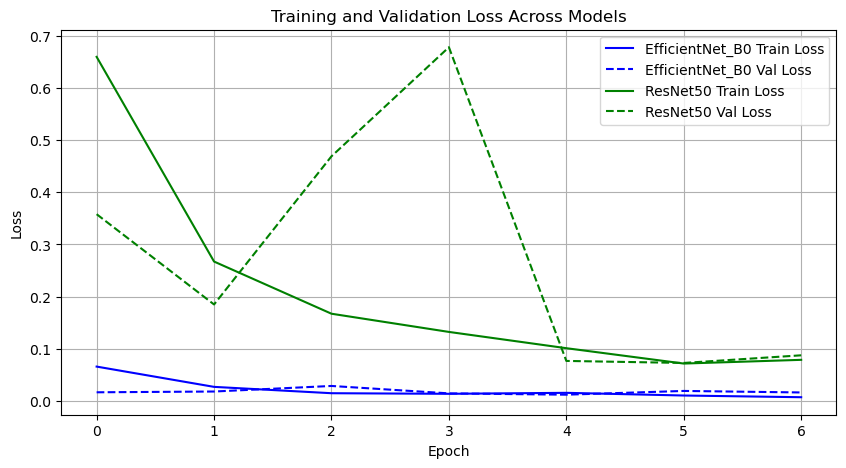

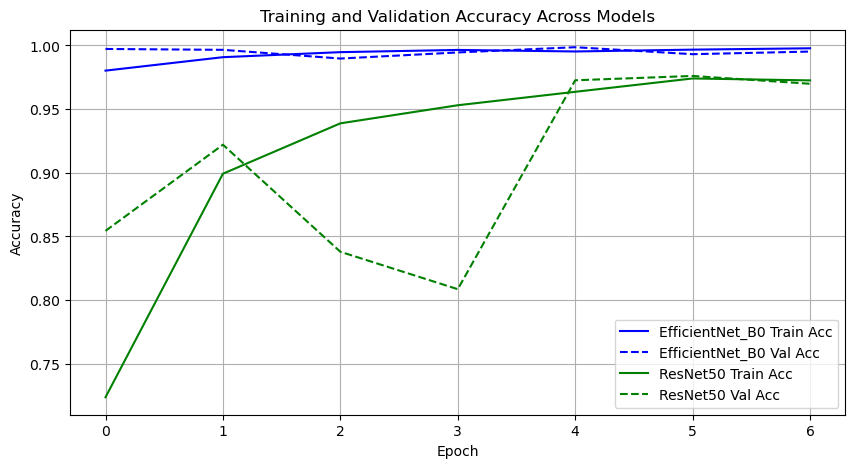

In [16]:
plot_metrics_from_json(model_names)

## Test function

### Test loop

In [29]:
def test_model(model, model_name, test_loader):
    model.eval()

    test_preds = []
    test_labels = []
    with torch.inference_mode():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Model"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy().tolist())
            test_labels.extend(labels.cpu().numpy().tolist())

    results = {
        "test_labels": [test_labels],
        "test_preds": [test_preds]
    }

    with open(f"{model_name}_predictions.json", "w") as f:
        json.dump(results, f)

    print(f"Predictions and labels saved to {model_name}_predictions.json")
    return test_labels, test_preds

# CALL TESTING

In [30]:
for model_name in model_names:
    print(f"Loading and testing model: {model_name}")
    
    model, _, _, _ = init_model(model_name)
    model.load_state_dict(torch.load(f"{model_name}_best_model.pth"))

    test_loader = test_loaders[model_name]
    test_model(model, model_name, test_loader)

Loading and testing model: EfficientNet_B0


/tmp/ipykernel_30/2822219086.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_name}_best_model.pth"))
Evaluating Model: 100%|███

Predictions and labels saved to EfficientNet_B0_predictions.json
Loading and testing model: ResNet50


Evaluating Model: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s]

Predictions and labels saved to ResNet50_predictions.json


## Metrics

In [13]:
def show_metrics(test_labels, test_preds, classes, model_name):
    # Metrics calculation
    accuracy = accuracy_score(test_labels, test_preds)
    precision = precision_score(test_labels, test_preds, average='weighted')
    recall = recall_score(test_labels, test_preds, average='weighted')
    f1 = f1_score(test_labels, test_preds, average='weighted')
    cm = confusion_matrix(test_labels, test_preds)

    # Display metrics
    print(f"Metrics for {model_name}:")
    print(f'  - Test Accuracy: {accuracy:.4f}')
    print(f'  - Precision: {precision:.4f}')
    print(f'  - Recall: {recall:.4f}')
    print(f'  - F1 Score: {f1:.4f}')
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# CALL PRINT METRICS

Metrics for EfficientNet_B0:
  - Test Accuracy: 0.9940
  - Precision: 0.9941
  - Recall: 0.9940
  - F1 Score: 0.9940


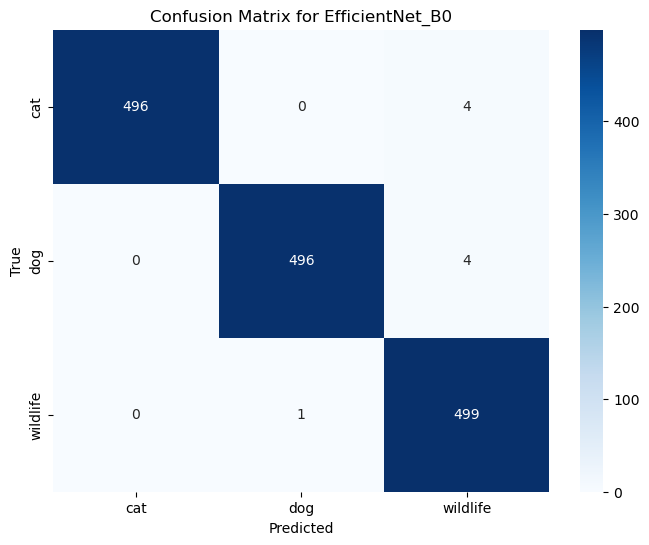

Metrics for ResNet50:
  - Test Accuracy: 0.9600
  - Precision: 0.9604
  - Recall: 0.9600
  - F1 Score: 0.9599


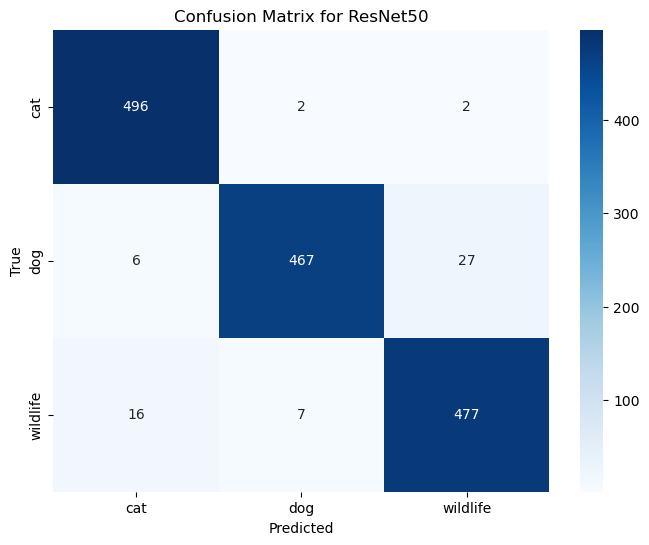

In [14]:
classes = ['cat', 'dog', 'wildlife']
for model_name in model_names:
    with open(f'{model_name}_predictions.json', 'r') as f:
        data = json.load(f)
    test_labels = np.array(data['test_labels']).flatten().tolist()
    test_preds = np.array(data['test_preds']).flatten().tolist()
    # classes = train_loader_classes[model_name]
    show_metrics(test_labels, test_preds, classes, model_name)